In [30]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [31]:
df =pd.read_sql_table('cloud', 'sqlite:///dissertation.db') 

In [32]:
df_copy = df.copy()

In [33]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451520 entries, 0 to 1451519
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   time        1451520 non-null  datetime64[ns]
 1   mean_power  1388702 non-null  float64       
 2   weekofyear  1451520 non-null  int64         
 3   day_name    1451520 non-null  int64         
 4   hour        1451520 non-null  int64         
 5   mins        1451520 non-null  int64         
 6   day_type    1451520 non-null  object        
 7   kWh         1451520 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 88.6+ MB


In [34]:
# group by half an hour
df_half = pd.DataFrame ({'Actual':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [9]:
# subset 80% of dataset for train and test, 20% for prediction
subset_num = 6451
df_train_test = df_half[['Actual']][:subset_num]
df_simul = df_half[['Actual']][subset_num:]

# transform 
#train_test=df_train_test.values
#train_test=train_test.astype('float32')

#simu=df_simu.values
#simu=simu.astype('float32')

In [10]:
size=1
df_train= df_train_test [:int(subset_num*size)]
df_test= df_train_test [int(subset_num*size):]
print(len(df_train),len(df_test))

6451 0


In [11]:
# test stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_train.Actual, regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.538009
p-value: 0.005715
Critial Values:
   1%, -4.372930274846424
Critial Values:
   5%, -3.8333073357597867
Critial Values:
   10%, -3.553828388730889


In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

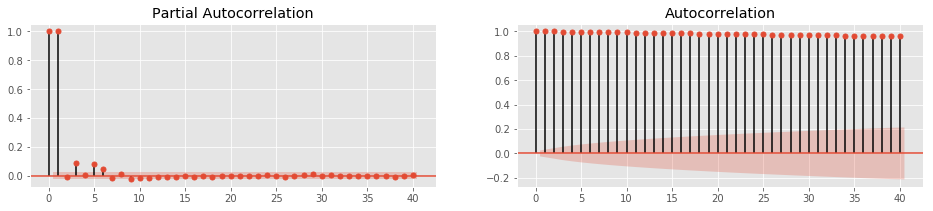

In [14]:
# one pacf and acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_pacf(df_train.Actual, lags=40, ax=axes[0])
plot_acf(df_train.Actual,lags=40, ax=axes[ 1])

plt.show()

In [23]:
# arima (2,1,1)
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_train, order=(3,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 Actual   No. Observations:                 6451
Model:                     ARMA(3, 2)   Log Likelihood               -1260.759
Method:                       css-mle   S.D. of innovations              0.294
Date:                Wed, 19 Aug 2020   AIC                           2535.519
Time:                        20:45:43   BIC                           2582.923
Sample:                    12-23-2019   HQIC                          2551.921
                         - 05-05-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           54.2234      5.614      9.658      0.000      43.219      65.227
ar.L1.Actual     1.2113      0.006    198.617      0.000       1.199       1.223
ar.L2.Actual     0.0058        nan        na

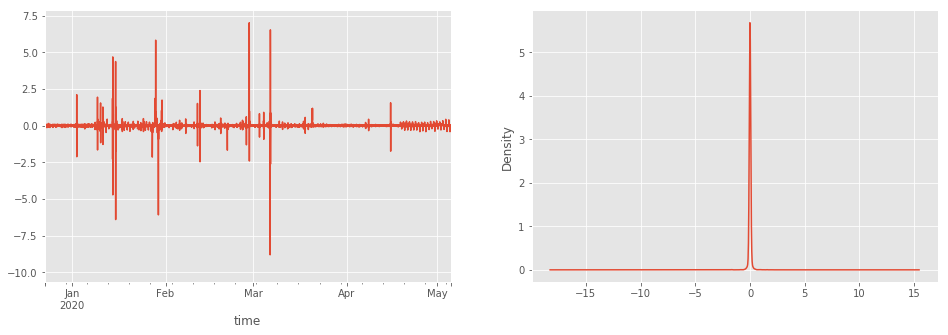

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
model_fit.resid.plot(ax=axes[0])
model_fit.resid.plot(kind='kde', ax=axes[1])

In [25]:
# predict the model
predict_train= model_fit.predict(dynamic=False)
#predict_test = model_fit0.predict(df_test.index[0],df_test.index[-1],dynamic=True)
#predict_simul = model_fit0.predict(df_s.index[0],df_simul.index[1],dynamic=True)

Text(0, 0.5, 'Wh')

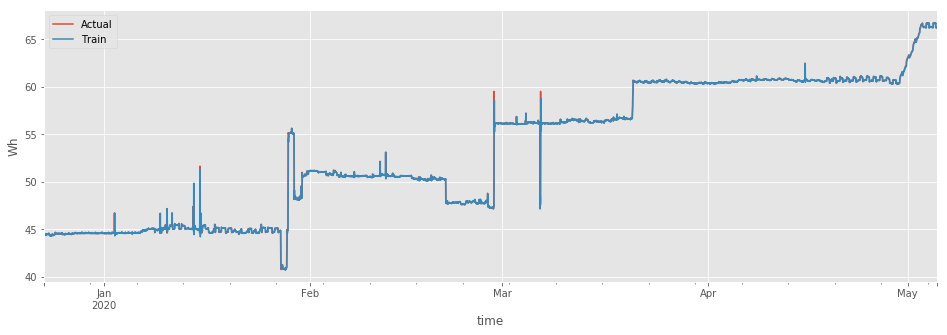

In [29]:
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_model_train= pd.DataFrame(predict_train, columns=({'Train'})).set_index(time_index[1:int(subset_num*size+1)])
#df_model_test= pd.DataFrame(predict_test, columns=({'Test'})).set_index(time_index[3+int(subset_num*size):6451+3])
#df_model_simu= pd.DataFrame(predict_simul, columns=({'Prediction'})).set_index(time_index[6451:])

df_all=pd.concat([df_half, df_model_train], axis=1)
#df_sub_pred = df_predict.merge(df_predict,left_on='time',right_on='time')



# plot the result
df_all[:6451].set_index(df_all[:6451].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [27]:
# next hour prediction
next_halfhour=model_fit.forecast(steps=1, exog=None, alpha=0.05)

print('Pred: ',next_halfhour[0],'Std: ',next_halfhour[1],'Confidence: ', next_halfhour[2])
print('Actual: ',df_half['Actual'][6451:6452])

Pred:  [66.22988353] Std:  [0.29404449] Confidence:  [[65.65356692 66.80620014]]
Actual:  time
2020-05-05 09:30:00    66.241667
Freq: 30T, Name: Actual, dtype: float64


In [28]:
mae = np.mean(np.abs(df_all['Train'][:6451] - df_all['Actual'][:6451]))
rmse = np.mean((df_all['Train'][:6451] - df_all['Actual'][:6451])**2)**.5

print('MAE: ', mae, 'RMSE: ',rmse)

MAE:  0.08351431059059172 RMSE:  0.43720557903168944


In [37]:
# with lockdown
mad_mean_ratio =0.0835*6451/df_half['Actual'][:6451].sum() 
mad_mean_ratio

0.0015662201748869343